In [ ]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

import sys
from typing import List

import shap
from boruta import BorutaPy
from sklearn.feature_selection import RFE

import xgboost as xgb
from catboost import CatBoostClassifier, Pool, EFstrType

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import prince

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

sys.path.append("..")

from src.data.dqc_layer import DQC

pd.set_option("display.max_columns", None)

In [23]:
data = pd.read_csv(
    "../data/raw/tree-data.csv",
    parse_dates=["created_at"],
    keep_default_na=False,
    na_values=["NA", "missing", ""],
)

* Removing features that contain the same information in essence and no-name features with no correllation with target feature

In [24]:
data.drop(["tree_id", "block_id"], axis=1, inplace=True)
data.drop(
    [
        "census tract",
        "bin",
        "bbl",
        "borough",
        "spc_common",
        "zip_city",
        "nta_name",
        "council district",
        "state",
    ],
    axis=1,
    inplace=True,
)

In [25]:
# Trees with 'Dead' or 'Stump' status have no health rating and are not analyzed
data.drop(["status"], axis=1, inplace=True)

In [26]:
data["month"] = data["created_at"].dt.month
data["day"] = data["created_at"].dt.day
data.drop(["created_at"], axis=1, inplace=True)

In [6]:
data.isnull().sum()

tree_dbh               0
stump_diam             0
curb_loc               0
health             31616
spc_latin          31619
steward            31615
guards             31616
sidewalk           31616
user_type              0
problems           31664
root_stone             0
root_grate             0
root_other             0
trunk_wire             0
trnk_light             0
trnk_other             0
brch_light             0
brch_shoe              0
brch_other             0
address                0
postcode               0
community board        0
borocode               0
cncldist               0
st_assem               0
st_senate              0
nta                    0
boro_ct                0
latitude               0
longitude              0
x_sp                   0
y_sp                   0
month                  0
day                    0
dtype: int64

In [27]:
data.dropna(subset=["health", "guards", "spc_latin", "sidewalk"], inplace=True)

In [28]:
def check_problems(row, problem_columns: List[str]) -> pd.Series:
    problems = ""
    for column in problem_columns[1:]:
        problem = "".join([chunk.capitalize() for chunk in column.split("_")])
        if row[column] == "Yes":
            problems += problem + ","
        elif pd.isna(row[column]):
            row["problems"] = np.nan
            return row

    if not problems:
        problems = "None"
    else:
        problems = problems[:-1]

    row["problems"] = problems
    return row


cols = data.loc[:, "problems":"brch_other"].columns
data.loc[:, "problems":"brch_other"] = data.loc[:, "problems":"brch_other"].apply(
    check_problems, axis=1, problem_columns=cols
)

In [8]:
data.isnull().sum()

tree_dbh           0
stump_diam         0
curb_loc           0
health             0
spc_latin          0
steward            0
guards             0
sidewalk           0
user_type          0
problems           0
root_stone         0
root_grate         0
root_other         0
trunk_wire         0
trnk_light         0
trnk_other         0
brch_light         0
brch_shoe          0
brch_other         0
address            0
postcode           0
community board    0
borocode           0
cncldist           0
st_assem           0
st_senate          0
nta                0
boro_ct            0
latitude           0
longitude          0
x_sp               0
y_sp               0
month              0
day                0
dtype: int64

* Outliers processing

In [29]:
min_tree_value = 0
max_tree_value = 457  # dbh of the world's thickest tree
outliers_idxs = data.loc[
    (data["tree_dbh"] < min_tree_value) | (data["tree_dbh"] > max_tree_value)
].index
data.drop(index=outliers_idxs, inplace=True)

* Data duplicates and inconsistency processing

In [30]:
data_dqc = DQC()

In [31]:
incost_idxs = data_dqc.consistency_uniqueness_check(
    data, consistency_columns=["health"]
)
data.drop(index=incost_idxs, inplace=True)


Number of conflicting or duplicated rows: 92


## Feature Selection

* Indexing categorical features for model training

In [10]:
data_vec = data.copy()

In [11]:
for column, dtype in data.dtypes.items():
    if dtype == np.object_:
        le = LabelEncoder()
        data_vec[column] = le.fit_transform(data[column])

In [12]:
X_vec = data_vec.drop("health", axis=1)
y_vec = data_vec["health"]

In [13]:
# Defining main model for feature selection methods
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=6,
    random_state=42,
    eval_metric="mlogloss",
    num_class=3,
)

### Boruta approach

In [ ]:
boruta_selector = BorutaPy(
    xgb_model, n_estimators="auto", random_state=42, max_iter=100, verbose=2
)

boruta_selector.fit(X_vec, y_vec)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	25
Tentative: 	3
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	3
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	3
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	3
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	3
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	25
Tentative: 	2
Rejected: 	6
I

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False,
                                 eval_metric='mlogloss', feature_types=None,
                                 gamma=None, grow_policy=None,
                                 importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=0.01, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=6,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=120,
                                 n_jobs=None, num_class=3,
                                 num_parallel_tree=None, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x18A185F9D40, verbose=2)

In [92]:
boruta_selected_features = X_vec.columns[boruta_selector.support_].to_list()
boruta2exclude = list(set(X_vec.columns) - set(boruta_selected_features))

print(f"Selected {len(boruta_selected_features)} features:", boruta_selected_features)
print("Features to exclude: ", boruta2exclude)

Selected 25 features: ['tree_dbh', 'spc_latin', 'steward', 'sidewalk', 'user_type', 'problems', 'root_other', 'trunk_wire', 'trnk_other', 'brch_light', 'brch_other', 'address', 'postcode', 'community board', 'cncldist', 'st_assem', 'st_senate', 'nta', 'boro_ct', 'latitude', 'longitude', 'x_sp', 'y_sp', 'month', 'day']
Features to exclude:  ['root_grate', 'stump_diam', 'root_stone', 'brch_shoe', 'guards', 'borocode', 'trnk_light', 'curb_loc']


### Recursive Feature Elimination

In [ ]:
num_features_to_select = 25

rfe = RFE(xgb_model, n_features_to_select=num_features_to_select, verbose=2)
rfe.fit(X_vec, y_vec)

Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


array(['tree_dbh', 'spc_latin', 'steward', 'sidewalk', 'user_type',
       'problems', 'root_other', 'trunk_wire', 'trnk_other', 'brch_light',
       'brch_other', 'address', 'postcode', 'community board', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'boro_ct', 'latitude', 'longitude',
       'x_sp', 'y_sp', 'month', 'day'], dtype=object)

In [93]:
rfe_selected_features = rfe.get_feature_names_out()
rfe2exclude = list(set(X_vec.columns) - set(rfe_selected_features))

print(f"Selected {len(rfe_selected_features)} features:", rfe_selected_features)
print("Features to exclude: ", rfe2exclude)

Selected 25 features: ['tree_dbh' 'spc_latin' 'steward' 'sidewalk' 'user_type' 'problems'
 'root_other' 'trunk_wire' 'trnk_other' 'brch_light' 'brch_other'
 'address' 'postcode' 'community board' 'cncldist' 'st_assem' 'st_senate'
 'nta' 'boro_ct' 'latitude' 'longitude' 'x_sp' 'y_sp' 'month' 'day']
Features to exclude:  ['root_grate', 'stump_diam', 'root_stone', 'brch_shoe', 'guards', 'borocode', 'trnk_light', 'curb_loc']


## Feature importance

* Getting categorical features for catboost algorithm

In [14]:
categorical_features = []

for column, dtype in data.dtypes.items():
    if dtype == np.object_:
        if column == "health":
            continue
        categorical_features.append(column)

categorical_features = categorical_features + [
    "postcode",
    "borocode",
    "cncldist",
    "st_assem",
    "st_senate",
]
print("Categorical features in the dataset: ", categorical_features)

Categorical features in the dataset:  ['curb_loc', 'spc_latin', 'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other', 'address', 'nta', 'postcode', 'borocode', 'cncldist', 'st_assem', 'st_senate']


In [15]:
# data for catboost training
X = data.drop("health", axis=1).copy()
y = data["health"].copy()

In [16]:
# Defining catboost model for feature importance extraction
cb_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    cat_features=categorical_features,
    loss_function="MultiClass",
    verbose=100,
)

In [17]:
train_pool = Pool(data=X, label=y, cat_features=categorical_features)
cb_model.fit(train_pool)

0:	learn: 1.0463522	total: 2s	remaining: 6m 38s
100:	learn: 0.5028313	total: 7m 9s	remaining: 7m
199:	learn: 0.4909489	total: 13m 37s	remaining: 0us


In [ ]:
cb_model.save_model("../models/catboost_model_fs.cbm")

* Loading the trained model from the saved ones, if available

In [83]:
cb_model = CatBoostClassifier().load_model("../models/catboost_model_fs.cbm")

In [18]:
extracted_importance = pd.DataFrame(
    {"feature": X.columns, "importance": cb_model.feature_importances_}
)
cb_feature_importance = extracted_importance.sort_values("importance", ascending=False)

print("\nExtracted from catboost model feature importance:")
print(cb_feature_importance)


Extracted from catboost model feature importance:
            feature  importance
3         spc_latin   17.062870
18          address   16.731270
0          tree_dbh   13.181595
7         user_type    9.708431
8          problems    9.423932
25              nta    8.318984
31            month    6.851576
19         postcode    5.967557
23         st_assem    1.686471
22         cncldist    1.570733
29             x_sp    1.321934
24        st_senate    1.216420
4           steward    1.073925
32              day    0.725667
28        longitude    0.669551
21         borocode    0.656685
17       brch_other    0.619319
30             y_sp    0.612484
14       trnk_other    0.485341
26          boro_ct    0.482439
27         latitude    0.440553
5            guards    0.409779
6          sidewalk    0.391544
20  community board    0.194727
9        root_stone    0.143028
12       trunk_wire    0.051065
16        brch_shoe    0.002119
15       brch_light    0.000000
11       root_other  

* Obtaining explainability for a trained catboost model and the impact on model output based on **SHAP values**

In [19]:
shap_values = cb_model.get_feature_importance(
    data=train_pool,
    type=EFstrType.ShapValues,
    prettified=True,
    log_cout=sys.stdout,
    log_cerr=sys.stderr,
)

In [20]:
class_count = data["health"].value_counts()
total_count = len(data["health"])
weights = [
    total_count / class_count["Fair"],
    total_count / class_count["Good"],
    total_count / class_count["Poor"],
]
weights

[6.757916770289315, 1.2331893087766737, 24.31912592758325]

In [21]:
weighted_shap = np.average(shap_values, axis=1, weights=weights)

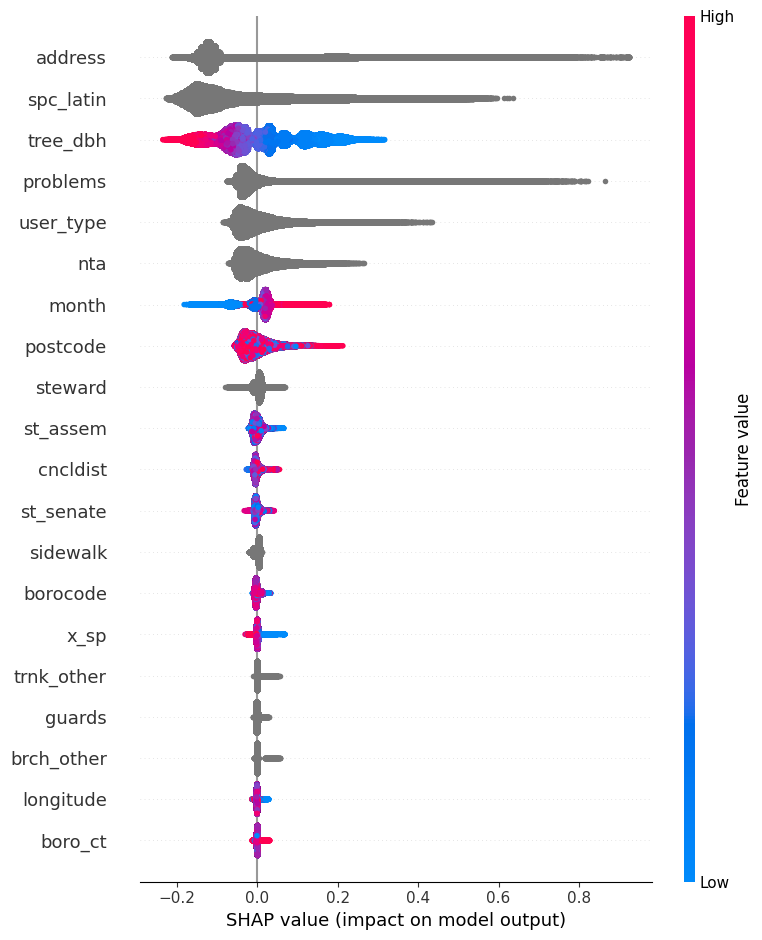

In [22]:
shap_mean = np.mean(shap_values, axis=1)
shap.summary_plot(weighted_shap[:, :-1], X, max_display=None)

In [96]:
print(boruta2exclude)
print(rfe2exclude)
print(cb_feature_importance[-10:])

['root_grate', 'stump_diam', 'root_stone', 'brch_shoe', 'guards', 'borocode', 'trnk_light', 'curb_loc']
['root_grate', 'stump_diam', 'root_stone', 'brch_shoe', 'guards', 'borocode', 'trnk_light', 'curb_loc']
            feature  importance
20  community board    0.194727
9        root_stone    0.143028
12       trunk_wire    0.051065
16        brch_shoe    0.002119
15       brch_light    0.000000
11       root_other    0.000000
13       trnk_light    0.000000
1        stump_diam    0.000000
2          curb_loc    0.000000
10       root_grate    0.000000


* Based on the results of the analysis, let's get rid of the least important features.
And we will combine some groups of features into separate features using dimensionality reduction methods.

In [32]:
data.drop(["community board", "stump_diam"], axis=1, inplace=True)

In [33]:
data_vec_fin = data.copy()

### Dimensionality reduction of **problems features**

In [34]:
mca = prince.MCA(n_components=1, random_state=42)
mca_problems = mca.fit_transform(data_vec_fin.loc[:, "root_stone":"brch_other"])

print(mca_problems.head())

          0
0 -0.206868
1  0.030875
2 -0.206868
3  0.030875
4  0.030875


In [35]:
data_vec_fin["problems"] = mca_problems
data["problems"] = mca_problems

data_vec_fin.drop(
    [
        "root_stone",
        "root_grate",
        "root_other",
        "trunk_wire",
        "trnk_light",
        "trnk_other",
        "brch_light",
        "brch_shoe",
        "brch_other",
    ],
    axis=1,
    inplace=True,
)
data.drop(
    [
        "root_stone",
        "root_grate",
        "root_other",
        "trunk_wire",
        "trnk_light",
        "trnk_other",
        "brch_light",
        "brch_shoe",
        "brch_other",
    ],
    axis=1,
    inplace=True,
)

In [36]:
with open("../models/preprocessors/mca_problems.pkl", "wb") as f:
    pickle.dump(mca, f)

### Dimensionality reduction of **tree growth conditions features**

In [37]:
mca = prince.MCA(n_components=1, random_state=42)
mca_tg_conditions = mca.fit_transform(
    data_vec_fin[["steward", "guards", "sidewalk", "curb_loc"]]
)

print(mca_tg_conditions.head())

          0
0 -0.286018
1 -0.372935
2  0.236712
3 -0.372935
4 -0.372935


In [38]:
data_vec_fin["tg_conditions"] = mca_tg_conditions
data_vec_fin.drop(["steward", "guards", "sidewalk", "curb_loc"], axis=1, inplace=True)

In [39]:
with open("../models/preprocessors/mca_tg_conditions.pkl", "wb") as f:
    pickle.dump(mca, f)

* Encoding of categorical features. And additional encoding of categorical features indicated by the number to reduce the order of the numbers used and reduce the amount of memory used to store these categories.

In [40]:
numeric_cat_features = [
    "postcode",
    "borocode",
    "cncldist",
    "st_assem",
    "st_senate",
    "boro_ct",
    "month",
    "day",
]

for column, dtype in data.dtypes.items():
    if dtype == np.object_:
        print(column)

        le = LabelEncoder()
        data_vec_fin[column] = le.fit_transform(data[column])

        with open(
            f"../models/preprocessors/label_encoders/{column}_label_encoder.pkl", "wb"
        ) as f:
            pickle.dump(le, f)
    elif column in numeric_cat_features:
        print(column)

        le = LabelEncoder()
        data_vec_fin[column] = le.fit_transform(data[column])

        with open(
            f"../models/preprocessors/label_encoders/{column}_label_encoder.pkl", "wb"
        ) as f:
            pickle.dump(le, f)

curb_loc
health
spc_latin
steward
guards
sidewalk
user_type
address
postcode
borocode
cncldist
st_assem
st_senate
nta
boro_ct
month
day


* Scaling of numerical features

In [41]:
num_columns = ["tree_dbh"]
scaler = MinMaxScaler()
num_features_scaled = scaler.fit_transform(data[num_columns])
num_features_scaled

array([[0.00705882],
       [0.04941176],
       [0.00705882],
       ...,
       [0.02823529],
       [0.02117647],
       [0.05411765]])

In [42]:
data_vec_fin[num_columns] = num_features_scaled
data[num_columns] = num_features_scaled

In [43]:
with open(f"../models/preprocessors/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

* Resampling dataset to tackle disbalance of target feature values

# Final Test

### Training model

In [ ]:
X_vec_fin = data_vec_fin.drop("health", axis=1).copy()
y_vec_fin = data_vec_fin["health"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_vec_fin, y_vec_fin, test_size=0.2, random_state=42
)

In [ ]:
new_cat_features = [
    "spc_latin",
    "user_type",
    "address",
    "postcode",
    "nta",
    "boro_ct",
    "month",
    "day",
]

In [ ]:
cat_boost = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    cat_features=new_cat_features,
    loss_function="MultiClass",
    verbose=100,
)

In [352]:
train_pool = Pool(data=X_train, label=y_train, cat_features=new_cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=new_cat_features)

In [353]:
cat_boost.fit(train_pool)

0:	learn: 1.0452828	total: 4.33s	remaining: 14m 22s
100:	learn: 0.4861735	total: 5m 7s	remaining: 5m 1s
199:	learn: 0.4745926	total: 10m 26s	remaining: 0us


In [328]:
print(accuracy_score(y_test, cat_boost.predict(test_pool)))
print(classification_report(y_test, cat_boost.predict(test_pool)))

0.831914991489949
              precision    recall  f1-score   support

           0       0.56      0.22      0.32     19153
           1       0.85      0.98      0.91    105973
           2       0.57      0.12      0.20      5308

    accuracy                           0.83    130434
   macro avg       0.66      0.44      0.48    130434
weighted avg       0.80      0.83      0.79    130434



### Feature importance extraction

In [339]:
extracted_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": cat_boost.feature_importances_}
)
cb_feature_importance = extracted_importance.sort_values("importance", ascending=False)

print("\nExtracted from catboost model feature importance:")
print(cb_feature_importance)


Extracted from catboost model feature importance:
          feature  importance
1       spc_latin   17.355245
11        boro_ct   13.891643
3        problems   12.259203
0        tree_dbh   11.938837
4         address    8.342456
17            day    8.336373
16          month    7.888739
2       user_type    5.666542
10            nta    3.262779
8        st_assem    2.111827
5        postcode    2.018553
18  tg_conditions    1.873134
9       st_senate    1.437073
6        borocode    1.070535
7        cncldist    0.849574
15           y_sp    0.471378
13      longitude    0.461711
12       latitude    0.394227
14           x_sp    0.370173


### Calculation of wheighted shap values

In [ ]:
cat_boost_shap_values = cat_boost.get_feature_importance(
    data=train_pool,
    type=EFstrType.ShapValues,
    prettified=True,
    log_cout=sys.stdout,
    log_cerr=sys.stderr,
)

Processing trees...
128/200 trees processed	passed time: 1.43s	remaining time: 805ms
200/200 trees processed	passed time: 2.33s	remaining time: 0us
Processing documents...
128/521732 documents processed	passed time: 6.45ms	remaining time: 26.3s
256/521732 documents processed	passed time: 14.3ms	remaining time: 29.1s
384/521732 documents processed	passed time: 20.3ms	remaining time: 27.5s
512/521732 documents processed	passed time: 27.3ms	remaining time: 27.7s
640/521732 documents processed	passed time: 33.1ms	remaining time: 27s
768/521732 documents processed	passed time: 39ms	remaining time: 26.4s
896/521732 documents processed	passed time: 45.5ms	remaining time: 26.5s
1024/521732 documents processed	passed time: 51.5ms	remaining time: 26.2s
1152/521732 documents processed	passed time: 57.3ms	remaining time: 25.9s
1280/521732 documents processed	passed time: 64.5ms	remaining time: 26.2s
1408/521732 documents processed	passed time: 71.1ms	remaining time: 26.3s
1536/521732 documents pro

In [358]:
class_count = data_vec_fin["health"].value_counts()
total_count = len(data_vec_fin["health"])
weights = [
    total_count / class_count[0],
    total_count / class_count[1],
    total_count / class_count[2],
]
weights

[6.757916770289315, 1.2331893087766737, 24.31912592758325]

In [359]:
weighted_shap = np.average(cat_boost_shap_values, axis=1, weights=weights)

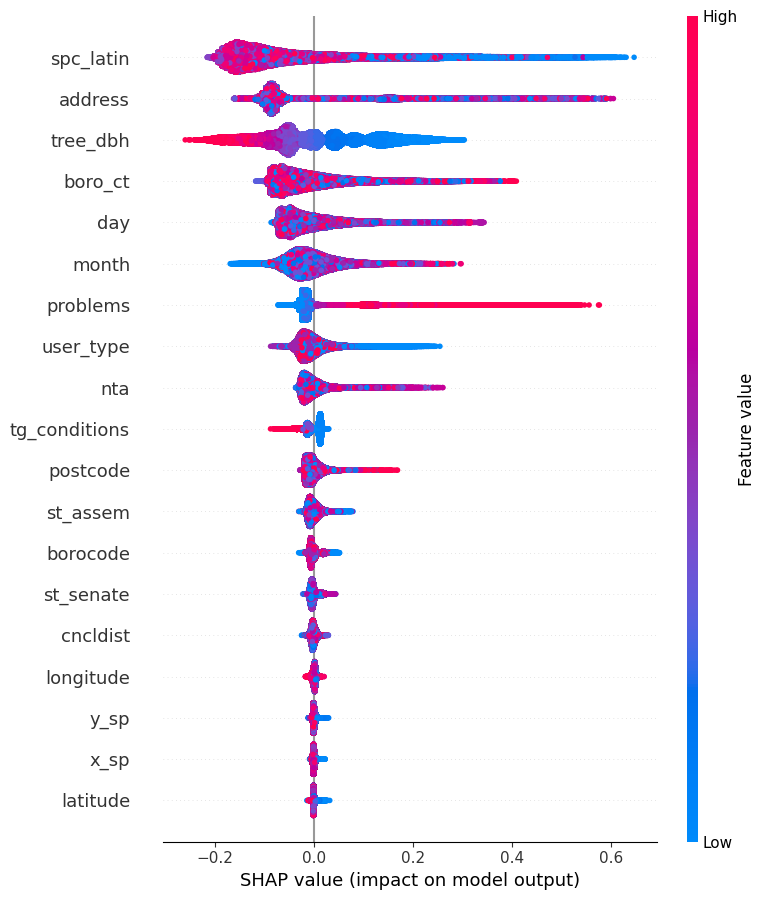

In [360]:
shap.summary_plot(weighted_shap[:, :-1], X_train, max_display=None)

### Final drop of insignificant features

In [44]:
data_vec_fin.drop(
    [
        "st_assem",
        "st_senate",
        "borocode",
        "cncldist",
        "y_sp",
        "x_sp",
        "latitude",
        "longitude",
    ],
    axis=1,
    inplace=True,
)
data.drop(
    [
        "st_assem",
        "st_senate",
        "borocode",
        "cncldist",
        "y_sp",
        "x_sp",
        "latitude",
        "longitude",
    ],
    axis=1,
    inplace=True,
)

* Re-checking data for duplicates and inconsistencies after deleting and transforming some features

In [50]:
incost_idxs = data_dqc.consistency_uniqueness_check(
    data, consistency_columns=["health"]
)
incost_vec_idxs = data_dqc.consistency_uniqueness_check(
    data_vec_fin, consistency_columns=["health"]
)


Number of conflicting or duplicated rows: 0

Number of conflicting or duplicated rows: 0


In [46]:
data.drop(index=incost_idxs)["health"].value_counts()

health
Good    502079
Fair     91593
Poor     25410
Name: count, dtype: int64

In [47]:
data.drop(index=incost_idxs, inplace=True)
data_vec_fin.drop(index=incost_vec_idxs, inplace=True)

In [48]:
data.to_csv("../data/processed/tree-data-processed.csv", index=False)

In [49]:
data_vec_fin.to_csv("../data/processed/tree-data-processed-vec.csv", index=False)